In [1]:
import numpy as np
import pandas as pd

import requests
import json,os,datetime
import csv
from pandas import DataFrame
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns #for beautiful plots
%matplotlib inline
import os
from datetime import datetime
from sklearn import decomposition
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve

Lo primero es depurar los datos, para ello vamos a eliminar los datos que no vamos a usar o que la informacion es redundante. Recordemos que la idea principal que vamos a tratar es realizar mediante machine learning una clasificacion de asteroides segun su grado de peligrosidad de colision con la tierra

In [2]:
data = pd.read_csv("nasa.csv")
data.keys()#veo los parametros y elijo cuales no me van a servir

Index(['Neo Reference ID', 'Name', 'Absolute Magnitude', 'Est Dia in KM(min)',
       'Est Dia in KM(max)', 'Est Dia in M(min)', 'Est Dia in M(max)',
       'Est Dia in Miles(min)', 'Est Dia in Miles(max)',
       'Est Dia in Feet(min)', 'Est Dia in Feet(max)', 'Close Approach Date',
       'Epoch Date Close Approach', 'Relative Velocity km per sec',
       'Relative Velocity km per hr', 'Miles per hour',
       'Miss Dist.(Astronomical)', 'Miss Dist.(lunar)',
       'Miss Dist.(kilometers)', 'Miss Dist.(miles)', 'Orbiting Body',
       'Orbit ID', 'Orbit Determination Date', 'Orbit Uncertainity',
       'Minimum Orbit Intersection', 'Jupiter Tisserand Invariant',
       'Epoch Osculation', 'Eccentricity', 'Semi Major Axis', 'Inclination',
       'Asc Node Longitude', 'Orbital Period', 'Perihelion Distance',
       'Perihelion Arg', 'Aphelion Dist', 'Perihelion Time', 'Mean Anomaly',
       'Mean Motion', 'Equinox', 'Hazardous'],
      dtype='object')

In [3]:
data.drop(columns=['Neo Reference ID','Equinox','Name','Orbiting Body',
                   'Est Dia in M(min)', 'Est Dia in M(max)',
           'Est Dia in Miles(min)', 'Est Dia in Miles(max)',
           'Est Dia in Feet(min)', 'Est Dia in Feet(max)',
           'Relative Velocity km per hr', 'Miles per hour',
           'Miss Dist.(lunar)', 'Miss Dist.(kilometers)', 'Miss Dist.(miles)',
           'Orbit Determination Date'], inplace=True)

In [4]:
#reviso si hay valores nulos en las columnas que quedaron
isnull = data.isnull()
for col in isnull.columns:
    print('Number of NULLS: '+" "+col+"=",sum(isnull[col]))

Number of NULLS:  Absolute Magnitude= 0
Number of NULLS:  Est Dia in KM(min)= 0
Number of NULLS:  Est Dia in KM(max)= 0
Number of NULLS:  Close Approach Date= 0
Number of NULLS:  Epoch Date Close Approach= 0
Number of NULLS:  Relative Velocity km per sec= 0
Number of NULLS:  Miss Dist.(Astronomical)= 0
Number of NULLS:  Orbit ID= 0
Number of NULLS:  Orbit Uncertainity= 0
Number of NULLS:  Minimum Orbit Intersection= 0
Number of NULLS:  Jupiter Tisserand Invariant= 0
Number of NULLS:  Epoch Osculation= 0
Number of NULLS:  Eccentricity= 0
Number of NULLS:  Semi Major Axis= 0
Number of NULLS:  Inclination= 0
Number of NULLS:  Asc Node Longitude= 0
Number of NULLS:  Orbital Period= 0
Number of NULLS:  Perihelion Distance= 0
Number of NULLS:  Perihelion Arg= 0
Number of NULLS:  Aphelion Dist= 0
Number of NULLS:  Perihelion Time= 0
Number of NULLS:  Mean Anomaly= 0
Number of NULLS:  Mean Motion= 0
Number of NULLS:  Hazardous= 0


# visualizacion

In [5]:
# quiero saber si las muestras tienen en orden de magnitud la misma cantidad de datos
print(f"Number of hazardous asteroids: {sum(data['Hazardous'].values == True)}")
print(f"Number of non-hazardous asteroids: {sum(data['Hazardous'].values == False)}")

Number of hazardous asteroids: 755
Number of non-hazardous asteroids: 3932


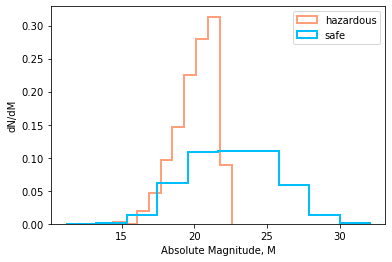

In [6]:
pel = (data['Hazardous'].values == True) #de peligroso
plt.hist(data['Absolute Magnitude'][pel], label='hazardous',
           histtype='step', density=True, color='lightsalmon', linewidth=2)
plt.hist(data['Absolute Magnitude'][~pel], label='safe',
           density=True, histtype='step', color='deepskyblue', linewidth=2)
plt.legend()
plt.xlabel('Absolute Magnitude, M')
plt.ylabel('dN/dM');

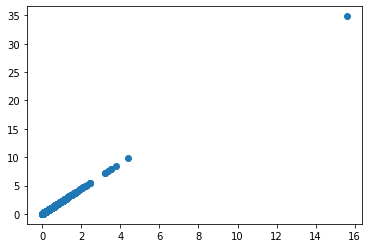

In [7]:
# seguimos sacando cosas redundantes, la relacion es lineal asique no nos sirve tener dos veces estos datos
plt.scatter(data['Est Dia in KM(min)'], data['Est Dia in KM(max)'])

In [8]:
data.drop(columns=['Est Dia in KM(max)'], inplace=True)

In [9]:
 #la columna que me dice si es peligroso o no la saco y defino el vector labels que me da 0 si no es peligroso y 1 si si lo es
labels = np.array(data['Hazardous'])
labels = np.array([1. if L else 0. for L in labels])
data.drop(columns=['Hazardous'], inplace=True)

In [10]:
data.keys()


Index(['Absolute Magnitude', 'Est Dia in KM(min)', 'Close Approach Date',
       'Epoch Date Close Approach', 'Relative Velocity km per sec',
       'Miss Dist.(Astronomical)', 'Orbit ID', 'Orbit Uncertainity',
       'Minimum Orbit Intersection', 'Jupiter Tisserand Invariant',
       'Epoch Osculation', 'Eccentricity', 'Semi Major Axis', 'Inclination',
       'Asc Node Longitude', 'Orbital Period', 'Perihelion Distance',
       'Perihelion Arg', 'Aphelion Dist', 'Perihelion Time', 'Mean Anomaly',
       'Mean Motion'],
      dtype='object')

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4687 entries, 0 to 4686
Data columns (total 22 columns):
Absolute Magnitude              4687 non-null float64
Est Dia in KM(min)              4687 non-null float64
Close Approach Date             4687 non-null object
Epoch Date Close Approach       4687 non-null int64
Relative Velocity km per sec    4687 non-null float64
Miss Dist.(Astronomical)        4687 non-null float64
Orbit ID                        4687 non-null int64
Orbit Uncertainity              4687 non-null int64
Minimum Orbit Intersection      4687 non-null float64
Jupiter Tisserand Invariant     4687 non-null float64
Epoch Osculation                4687 non-null float64
Eccentricity                    4687 non-null float64
Semi Major Axis                 4687 non-null float64
Inclination                     4687 non-null float64
Asc Node Longitude              4687 non-null float64
Orbital Period                  4687 non-null float64
Perihelion Distance             4687

In [12]:
# por las dudas esta no se si tirarla o no asique convierto el string en un numero, la cantidad de dias la cuento en funcion del valor mas chico que se ve a ojo
data['Close Approach Date'][0]
from datetime import datetime
ref = datetime.strptime('1950-01-01', '%Y-%m-%d')
dates = []
for d in data['Close Approach Date']:
    day = datetime.strptime(d, '%Y-%m-%d')
    dif = (day - ref).days
    dates.append(dif)
# aca piso los datos de pandas y obtengo la nueva columna con los datos de los dias.
data['Close Approach Date'] = dates
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4687 entries, 0 to 4686
Data columns (total 22 columns):
Absolute Magnitude              4687 non-null float64
Est Dia in KM(min)              4687 non-null float64
Close Approach Date             4687 non-null int64
Epoch Date Close Approach       4687 non-null int64
Relative Velocity km per sec    4687 non-null float64
Miss Dist.(Astronomical)        4687 non-null float64
Orbit ID                        4687 non-null int64
Orbit Uncertainity              4687 non-null int64
Minimum Orbit Intersection      4687 non-null float64
Jupiter Tisserand Invariant     4687 non-null float64
Epoch Osculation                4687 non-null float64
Eccentricity                    4687 non-null float64
Semi Major Axis                 4687 non-null float64
Inclination                     4687 non-null float64
Asc Node Longitude              4687 non-null float64
Orbital Period                  4687 non-null float64
Perihelion Distance             4687 

In [13]:
#esto parece ser lo que entrena los datos, yo le doy los datos en data y le digo que esos datos van en relacion
#al vector labels, quiero que me haga un test con un cuarto de la muestra y se entrene con el otro tercio
res = train_test_split(data, labels, test_size = 0.25, random_state = 42)
train_features, test_features, train_labels, test_labels = res

In [20]:
# vemos como se hizo el test 1172 que es 1 cuarto y los otros tres cuartos se usaron para entrenar el RF 
print(test_features.shape)
print(train_features.shape)
print(data.shape)

(47, 22)
(4640, 22)
(4687, 22)


# RANDOM FOREST REGRESSION

In [30]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import jaccard_score


Obtenemos solo 3 puntos por que los posibles valores de la columna "Hazardous' son binarios entonces pueden ser (0,0) , (1,1) o los falsos positivos (0,1)

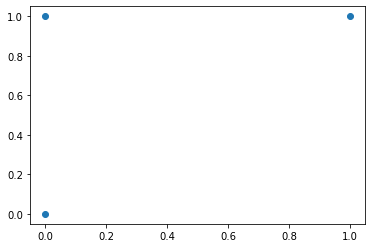

In [54]:
rf = RandomForestRegressor(n_estimators = 20, bootstrap=True)
res = train_test_split(data, labels, test_size = 0.01, random_state = 10)
train_features, test_features, train_labels, test_labels = res
rf.fit(train_features, train_labels)
predictions = rf.predict(test_features)
a, b, c = roc_curve(test_labels, predictions)
plt.scatter(a, b)

In [39]:
# fit es el parametro que se usa para entrenar y predict para aplicarlo a los datos
rf.fit(train_features, train_labels)

y_pred = rf.predict(test_features)
y_pred = np.rint(y_pred).astype(int)

In [40]:
predictions = rf.predict(test_features)

In [48]:
len( test_labels)

47

In [41]:
#accuracy 
errors = abs(predictions - test_labels)
print('Accuracy=', np.sum(errors < 1.e-5)/ len(test_labels))

Accuracy= 1.0


In [49]:
#esta funcion compara el conjunto de etiquetas predichas para una muestra con el conjunto correspondiente de etiquetas
jaccard_score( test_labels , y_pred ,  average = 'binary')

1.0

# REDUCCIOND DE DIMENSIONES: Manual y PCA

features nuevos [1.00000000e+00 4.37855979e-17 3.43410492e-18 5.83145976e-19]
el valor de compaaracion es: 0.1
Accuracy= 0.5319148936170213
el valor de comparacion es: 0.0
Accuracy= 0.0851063829787234


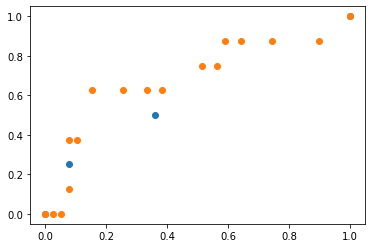

In [64]:
#aca veo que solo con una rotacion en algun eje hay un solo feature que vale la pena considerar, aunque pierdo interpretabildad de los datos, veamos si de la forma manual existe otra posibilidad
pca = decomposition.PCA(n_components=4)

pca.fit(data)
Reduc = pca.transform(data)        

print('features nuevos',pca.explained_variance_ratio_)


# RF (con 3 arboles)
rf = RandomForestRegressor(n_estimators = 3, bootstrap=True)
res = train_test_split(Reduc, labels, test_size = 0.01, random_state = 10)
train_features, test_features, train_labels, test_labels = res
rf.fit(train_features, train_labels)
predictions = rf.predict(test_features)
a, b, c = roc_curve(test_labels, predictions)
plt.scatter(a, b,label='3 arboles')
rf.fit(train_features, train_labels)
y_pred = rf.predict(test_features)
y_pred = np.rint(y_pred).astype(int)
print('el valor de compaaracion es:' , jaccard_score( test_labels , y_pred ,  average = 'binary'))
errors = abs(predictions - test_labels)
print('Accuracy=', np.sum(errors < 1.e-5)/ len(test_labels))
plt.legend()

# RF (con 50 arboles)
rf = RandomForestRegressor(n_estimators = 50, bootstrap=True)
res = train_test_split(Reduc, labels, test_size = 0.01, random_state = 10)
train_features, test_features, train_labels, test_labels = res
rf.fit(train_features, train_labels)
predictions = rf.predict(test_features)
a, b, c = roc_curve(test_labels, predictions)
plt.scatter(a, b,label='50 arboles')
rf.fit(train_features, train_labels)
y_pred = rf.predict(test_features)
y_pred = np.rint(y_pred).astype(int)
print('el valor de comparacion es:' , jaccard_score( test_labels , y_pred ,  average = 'binary'))
errors = abs(predictions - test_labels)
print('Accuracy=', np.sum(errors < 1.e-5)/ len(test_labels))
plt.legend()

el valor de compaaracion es: 0.3
Accuracy= 0.7446808510638298
el valor de compaaracion es: 0.4444444444444444
Accuracy= 0.5319148936170213


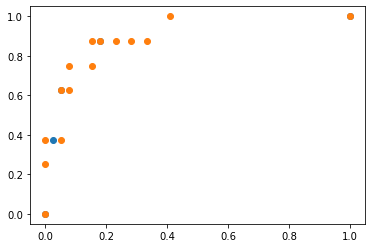

In [63]:
#reduccion manual
d = data[['Absolute Magnitude','Orbital Period','Inclination',
          'Est Dia in KM(min)','Eccentricity']]

# RF (con 3 arboles)
rf = RandomForestRegressor(n_estimators = 3, bootstrap=True)
res = train_test_split(d, labels, test_size = 0.01, random_state = 10)
train_features, test_features, train_labels, test_labels = res
rf.fit(train_features, train_labels)
predictions = rf.predict(test_features)
a, b, c = roc_curve(test_labels, predictions)
plt.scatter(a, b,label='3 arboles')
rf.fit(train_features, train_labels)
y_pred = rf.predict(test_features)
y_pred = np.rint(y_pred).astype(int)
print('el valor de compaaracion es:' , jaccard_score( test_labels , y_pred ,  average = 'binary'))
errors = abs(predictions - test_labels)
print('Accuracy=', np.sum(errors < 1.e-5)/ len(test_labels))
plt.legend()

# RF (con 50 arboles)
rf = RandomForestRegressor(n_estimators = 50, bootstrap=True)
res = train_test_split(d, labels, test_size = 0.01, random_state = 10)
train_features, test_features, train_labels, test_labels = res
rf.fit(train_features, train_labels)
predictions = rf.predict(test_features)
a, b, c = roc_curve(test_labels, predictions)
plt.scatter(a, b,label='50 arboles')
rf.fit(train_features, train_labels)
y_pred = rf.predict(test_features)
y_pred = np.rint(y_pred).astype(int)
print('el valor de comparacion es:' , jaccard_score( test_labels , y_pred ,  average = 'binary'))
errors = abs(predictions - test_labels)
print('Accuracy=', np.sum(errors < 1.e-5)/ len(test_labels))
plt.legend()

# Conclusion
Cuando hacemos la asignacion de etiquetas usando random Forest vemos a traves del calculo de Acurrancy algo que tambien se puede visualizar en la curva Roc, la clasificacion de un asteroide si es peligroso o no se hace justamente con un arbol de desiciones. Al aplicarle el proceso de un aprendizaje supervisado que son arboles de desiciones recuperamos el resultado. Esto nos da rienda suelta a explorar mas con el metodo y ver si al reducir las dimensiones (lo hacemos de dos maneras) y comparamos la acurrancy que es un parametro numerico que nos dice que tan bueno es mi modelo para predicir valores y con otra funcion  jaccard que nos dice solo en el caso binario. Llegamos a la conclusion que aparte de la solucion trivial encontrada, haciendo reducccion de dimension manual y con 3 arboles se llega a una muy buena deteccion de etiquetas del modelo, se propone ahora una reduccion sistematica en trabajos futuros donde se hagan varios conjuntos de data y se eliminen sistematicamente algunas columnas para lograr una mejor eficiencia de los modelos y encontrar los features que combina PCA para asignar estas etiquetas.